# Weeks 12-13: Object localization

## General instructions

Every two weeks you will be given an assignment related to the associated module. You have roughly two weeks to complete and submit each of them. There are three weekly group sessions available to help you complete the assignments. Attendance is not mandatory but recommended. However, all assignments are graded and not submitting them or submitting them after the deadline will give you no points.

**FORMAT**: Jupyter notebook **(single file, not in a zip please!)**

**DEADLINE**: Sunday 11th April, 23:59

## Introduction

The objective of this assignment is to get a basic understanding of the core concepts in object detection using convolutional neural networks. More specifically, this work focuses on the simpler problem of object localization, where each image contains a single object that should be spatially localized and classified. While object localization is simpler than object detection in the sense that object detection is more general as it allows for multiple objects per scene, object localization remains a rather avanced method, perfectly suited for our current level. This exercise consists of two parts:
- To begin with, we will get familiar with the sliding window algorithm, and notice that applying a convolutional neural network sequentially to a specific set of windows within an image is in fact mathematically equivalent to passing the whole image as input for the convolutional neural network. We will in particular try to understand what parameters determine which set of windows will be processed by the convolutional sliding window algorithm and we will run a performance comparison between the sequential and convolutional implementations.
- In a second part, we will implement in pytorch our own take on the object localization algorithm. For that purpose, the knowledge acquired in the first part of this assignment will be helpful, as we will try to implement object localization using a convolutional sliding window approach. In order for us to be able to train and test our network even on modest hardware, this exercise will have you work on a custom dataset: you will use the MNIST dataset as a backbone to generate new images with digits randomly placed and transformed, and each image will contain a single digit. While solving object localization on this custom dataset will be much easier than traditional object detection on large datasets such as COCO, it will still require clever vectorized coding if you hope to train your network in a reasonable amount of time !

## Andrew's Videos related to this week's assignment

- [C4W3L01 Object Localization](https://www.youtube.com/watch?v=GSwYGkTfOKk&list=PL_IHmaMAvkVxdDOBRg2CbcJBq9SY7ZUvs)
- [C4W3L03 Object Detection](https://www.youtube.com/watch?v=5e5pjeojznk&list=PL_IHmaMAvkVxdDOBRg2CbcJBq9SY7ZUvs&index=3)
- [C4W3L04 Convolutional Implementation Sliding Window](https://www.youtube.com/watch?v=XdsmlBGOK-k&list=PL_IHmaMAvkVxdDOBRg2CbcJBq9SY7ZUvs&index=4)

# Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm

torch.backends.cudnn.benchmark = True

# Convolutional sliding window

The sliding window algorithm refers to any procedure that applies a certain function ("map") to sliding windows within an image. In its typical forumaltion, this seems to be an inherently sequential algorithm: process the first window, then the second etc$\dots$ assuming the function to apply on every window is a convolutional neural network, an interesting fact arises: the sequential implemention of sliding window for this convolutional neural network map becomes exactly equivalent to passing the whole image as input to the convolutional neural network. We will investigate this fact further in this section. Answer the following questions:

1) Watch Andrew's video about convolutional sliding window implementation.

2) What slight modification is needed on the convolutional neural network such that sequential and convolutional sliding window procedures for this convolutional neural network map become equivalent ?

**ANSWER:** *ConvNet must be for smaller images(?). And we must exchange fc layers with 1x1 conv layers*

3) Reproduce the convolutional neural network from Andrew's video (1:20), and verify that for an input tensor with spatial dimension $16\times 16$, convolutional sliding window for that convolutional neural network map is the same as a sequential sliding window with stride $2$ along both spatial dimension. You can for instance compute the norm of the difference between the output tensors from convolutional and sequential implementations and check that this norm is indeed $0.0$.

**ANSWER:** In a cell below

4) What happens when the input tensor now has spatial dimensions $28\times 28$? Try a few other spatial dimensions. Can you find some such that convolutional and sequential procedures yield different outputs ?

**ANSWER:** It results in a tensor that is the same as a sliding window approach with a stride of 2 and windowsize of 14. And i tried a few different networks (before i read the rest of the questions...). And found that the stride changes as we introduce more maxpool-layers. This kind of makes sense, as if we only have convolutional layers (without padding) we will inevitably shrink the height and width. When we introduce maxpools, we sort of skip some convolutional layers to get a smaller height and width. 

5) Do a time comparison for various input spatial dimensions between convolutional and sequential sliding window procedures for Andrew's convolutional network map. Which is the most efficient ? Can you explain why ?

**ANSWER:** The convolutional is way more efficient. This is because there is a lot of computational overlap between the different windows. When we use a sliding window approach the overlaps are calculated again and again, whereas in a convolutional approach they are only calculated once.

6) Modify slightly Andrew's convolutional neural network such that there is now an additional convolutional layer. Do convolutional and sequential sliding window with stride $2$ procedures still coincide ? If not, what should be the stride for them to coincide again ?

**ANSWER:** Stride is still the same, so yes they coinside still.

7) Same question but now add an additional max pooling layer (with kernel size $2$) instead.

**ANSWER:** Now the stride has doubled to 4! 

*Note:* I created a new network for testing both of these. Should in hindsight just have made a function...

8) It turns out that the architecture of the convolutional neural network map itself will determine what is the set of windows for which convolutional and sequential sliding window procedures coincide for that convolutional neural network map. In the following, let us assume that all convolutional layers have padding $0$ and all max pooling layers have kernel size $2$. Can you guess the formulas that give the number of windows and their indices ? $\textbf{Hint}$: Remember your implementation of the Conv2d layer. $\textbf{If you can't find this, CONTACT US!}$ It will be important in the second section.

**ANSWER:**   
The output height and width of convolutional layers are calculated as seen below:

H_out = (H_in + 2*padding[0] - kernel[0]) // stride[0] + 1

W_out = (H_in + 2*padding[1] - kernel[1]) // stride[1] + 1


We can modify these to fit our new objective. I got the following functions to calculate the output-shape

H = floor(H_image - H_window / 2^(N_pool)) + 1

W = floor(W_image - W_window / 2^(N_pool)) + 1




In [2]:

class AndrewNet(nn.Module):
    def __init__(self):
        super(AndrewNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 400, kernel_size = 5)
        self.conv3 = nn.Conv2d(in_channels = 400, out_channels = 400, kernel_size = 1)
        self.conv4 = nn.Conv2d(in_channels = 400, out_channels = 4, kernel_size = 1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.conv1(x)  #
        x = self.maxpool(x)# 5
        
        x = self.conv2(x)  
        x = self.conv3(x)
        x = self.conv4(x)

        return x
    
class AndrewNetModified(nn.Module): 
    def __init__(self):
        super(AndrewNetModified, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3)
        self.additionalconv = nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 400, kernel_size = 5)
        self.conv3 = nn.Conv2d(in_channels = 400, out_channels = 400, kernel_size = 1)
        self.conv4 = nn.Conv2d(in_channels = 400, out_channels = 4, kernel_size = 1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.additionalconv(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        return x

class AndrewNetMaxpool(nn.Module):
    def __init__(self):
        super(AndrewNetMaxpool, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 400, kernel_size = 3)
        self.conv3 = nn.Conv2d(in_channels = 400, out_channels = 400, kernel_size = 2)
        self.conv4 = nn.Conv2d(in_channels = 400, out_channels = 4, kernel_size = 1)
        
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.conv1(x)  # 12
        x = self.maxpool(x)# 6
        x = self.conv2(x)  # 4
        x = self.maxpool(x)# 2
        x = self.conv3(x)  # 1
        x = self.conv4(x)  # 1
        
        return x
        

def compareSlidingAndConvolutional(input_tensor, model, windowsize, stride, print_segment_norms = False):
    total_loss = 0.0
    conv_result = model(input_tensor)
    _, c, h_out, w_out = conv_result.shape
    for h in range(h_out):
        for w in range(w_out):
            res_segment = conv_result[:,:,h,w]
            new_segment = model(input_tensor[:,:,h*stride : h*stride + windowsize, w*stride : w*stride + windowsize])
            if print_segment_norms:
                print(torch.linalg.norm(res_segment.squeeze_()), torch.linalg.norm(new_segment.squeeze_()))
            total_loss += torch.linalg.norm(res_segment.squeeze_()) - torch.linalg.norm(new_segment.squeeze_())
    return total_loss



andrewNet = AndrewNet()
modifiedNet = AndrewNetModified()
modifiedMaxpoolNet = AndrewNetMaxpool()
test_tensor = torch.rand(10,3,16,16)
larger_test_tensor = torch.rand(10,3,28,28)


print("\n ----------- ANDREW NET ------------")
print("Normal:    ", compareSlidingAndConvolutional(test_tensor, andrewNet, windowsize=14, stride=2))
print("Larger:    ", compareSlidingAndConvolutional(larger_test_tensor,andrewNet, windowsize=14, stride=2))


# ModifiedNet
print("\n ----------- MODIFIED NET ------------")
print("Normal:    ", compareSlidingAndConvolutional(test_tensor,modifiedNet, windowsize=14, stride=2))
print("Larger:    ", compareSlidingAndConvolutional(larger_test_tensor,modifiedNet, windowsize=14, stride=2))


# ModifiedNet
print("\n ----------- MODIFIED NET (MAXPOOL) ------------ NOTE STRIDE = 4")
print("Normal:    ", compareSlidingAndConvolutional(test_tensor,modifiedMaxpoolNet, windowsize=14, stride=4))
print("Larger:    ", compareSlidingAndConvolutional(larger_test_tensor,modifiedMaxpoolNet, windowsize=14, stride=4))



#even_larger_test_tensor = torch.rand(10,3,64,64)
#print(compareSlidingAndConvolutional(even_larger_test_tensor,andrewNet, windowsize=14, stride=2))



 ----------- ANDREW NET ------------
Normal:     tensor(0., grad_fn=<AddBackward0>)
Larger:     tensor(0., grad_fn=<AddBackward0>)

 ----------- MODIFIED NET ------------
Normal:     tensor(0., grad_fn=<AddBackward0>)
Larger:     tensor(0., grad_fn=<AddBackward0>)

 ----------- MODIFIED NET (MAXPOOL) ------------ NOTE STRIDE = 4
Normal:     tensor(0., grad_fn=<AddBackward0>)
Larger:     tensor(0., grad_fn=<AddBackward0>)


# MNIST localization in Pytorch

## 1 Data generation

In this second section we aim to implement from scratch our custom digit localization algorithm. We will use the MNIST dataset as a backbone:

In [3]:
def load_MNIST(MNIST_path, preprocessor, num_workers):
    train_dataset = datasets.MNIST(MNIST_path, train=True, transform=preprocessor)
    val_test_dataset = datasets.MNIST(MNIST_path, train=False, transform=preprocessor)
    n_val_test = len(val_test_dataset.targets)
    # The test set will only contain 30 images, perfect for visualization purpose:
    val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [n_val_test-30, 30])
    MNIST_datasets = {"train": train_dataset, 
                      "val": val_dataset,
                      "test": test_dataset}
    MNIST_generators = {"train": torch.utils.data.DataLoader(MNIST_datasets["train"], 
                                                             batch_size=4, 
                                                             shuffle=True, 
                                                             num_workers=num_workers),
                        "val": torch.utils.data.DataLoader(MNIST_datasets["val"], 
                                                           batch_size=256, 
                                                           shuffle=False, 
                                                           num_workers=num_workers),
                        "test": torch.utils.data.DataLoader(MNIST_datasets["test"], 
                                                            batch_size=30, 
                                                            shuffle=False, 
                                                            num_workers=num_workers)}
    return MNIST_datasets, MNIST_generators

We now want to have a digit generator in pytorch that would produce samples "on the fly" for the digit localization task. The problem we have is that all MNIST digits are centered, have the same orientation and roughly the same size which makes the localization task pretty dull. 

**1) Write a data preprocessor that would do the following:**

**a) Randomly rotates digits.**

**b) Randomly rescales digits with a scale factor randomly sampled in the range [0.75,1.25].**

**c) Randomly places digits within a zeros tensor having spatial dimensions $64\times 64$.**

**You can make sure your data generator works as intended by visualizing the test set generated by MNIST_generators["test"]. Each image generated this way should contain one and exactly one digit!**

In [4]:

MNIST_path = "../data/"

class RandomPadder:
    def __init__(self, size):
        self.size = size

    def __call__(self, x):
        frame = torch.zeros(1, self.size, self.size)
        c, h, w = x.shape
        hplacement = np.random.randint(0, 64 - h)
        wplacement = np.random.randint(0, 64 - w)

        frame[:, hplacement:hplacement + h, wplacement: wplacement + w] = x
        return frame





## 2 Convolutional sliding window

We then need to implement the convolutional neural network that will do the heavy work. In a nutshell, we want to have a CNN that is able to locate and classify digits within input images with base dimensions $(h\_in, w\_in)$. Then, we use this CNN as the backbone mapping in a sliding window procedure, in order to be able to locate and classify digits within larger images with dimensions $(H\_in, W\_in)$ such that $H\_in > h\_in$ and $W\_in > w\_in$. In the first section, you learned how to perform this efficiently by converting the sequential sliding window procedure into a convolutional one. More specifically, you learned that passing directly the whole large image to the CNN mapping gives an output tensor whose spatial dimensions $(H\_out, W\_out)$ correspond to the number of sliding windows in the sequential procedure such that each cell is exactly the output of the CNN applied to the corresponding window. Moreover, you also are able to find the indices of these windows. 

**2) Use this knowledge in order to implement the CNN you'll be using for the digit localization task. Remember that the window size $(h\_in, w\_in)$ should be large enough to contain digits entirely and the input size $(H\_in, W\_in)$ should match the dimensions of the tensors produced by you generator, namely $64\times 64$.**


In [5]:

# Since we have this RandomPadder function, the largest one of the input images can be is 35px by 35px. 

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 24, kernel_size = 4)
        self.conv2 = nn.Conv2d(in_channels = 24, out_channels = 120, kernel_size = 4)
        self.conv3 = nn.Conv2d(in_channels = 120, out_channels = 400, kernel_size = 5)
        self.conv4 = nn.Conv2d(in_channels = 400, out_channels = 400, kernel_size = 1)
        self.conv5 = nn.Conv2d(in_channels = 400, out_channels = 1 + 10 + 4, kernel_size = 1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        # Assuming input size of x.shape = 30x30x3
        
        x = self.conv1(x)
        # x.shape: 26x26x24

        x = self.maxpool(x)
        # x.shape: 13x13x24
        
        x = self.conv2(x)
        # x.shape: 10x10x120
        
        x = self.maxpool(x)
        # x.shape: 5x5x120
        
        x = self.conv3(x)
        # x.shape: 1x1x400
        
        x = self.conv4(x)
        # x.shape: 1x1x400
        
        x = self.conv5(x)
        # x.shape: 1x1x15

        return x 

class NewCNN(nn.Module):
    def __init__(self):
        super(NewCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride = 1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1)
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Conv2d(64, 400, kernel_size = 5)
        self.fc2 = nn.Conv2d(400, 400, kernel_size = 1)
        self.fc3 = nn.Conv2d(400, 15, kernel_size = 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.bn1(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.bn2(x)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x


test_tensor = torch.rand(10,1,64,64)
cnn = MyCNN()
cnn(test_tensor).shape

newcnn = NewCNN()
print(newcnn(test_tensor).shape)

torch.Size([10, 15, 10, 10])




## 3 Bounding box extraction, encoding

At the moment, we only have access to the digit labels. This is not sufficient for the task of digit localization: we need those bounding boxes, so we will produce them ourselves ! 

**3-1) Implement a code that will produce sharp bounding boxes around a digit. You can for instance use torch.where(... > 0.0) to find the limits of the digit in an image.**


In [6]:
# images[0][0].permute(1,2,0)
def BoundingBoxExtraction(image_tensor):

    contains_digit = torch.where(image_tensor > 0.0, 1, 0)
    px_values = torch.nonzero(contains_digit)

    if px_values.numel() == 0:
        return

    _, max_y, max_x = torch.max(px_values, dim=0).values
    _, min_y, min_x = torch.min(px_values, dim=0).values
    
    return max_x, min_x, max_y, min_y



In [213]:


class EncodingProcedure:
    def __init__(self, stride, windowsize, out_shape):
        self.stride = stride
        self.windowsize = windowsize
        self.out_shape = out_shape

    def __call__(self, x):
        N, H_out, W_out = self.out_shape
        Y_true = torch.zeros(size=(6, H_out, W_out))
        right, left, bottom, top = BoundingBoxExtraction(x)
        
        for h in range(H_out):
            for w in range(W_out):
                
                h_start = h * self.stride
                w_start = w * self.stride
                h_end = h * self.stride + self.windowsize
                w_end = w * self.stride + self.windowsize
                
                
                # h_start = top
                # h_end = bottom
                # w_start = left
                # w_end = right
                
                vertical = top > h_end or bottom < h_start
                horizontal = right < w_start or left > w_end 
                #if not(right < w_start or left > w_end or top > w_end or bottom < w_start):
                if not(vertical or horizontal):

                    y2 = (top-h_start) / self.windowsize
                    y3 = (bottom-h_start) / self.windowsize
                    y4 = (left-w_start) / self.windowsize
                    y5 = (right-w_start) / self.windowsize
                    
                    Y_true[:,h,w] = torch.tensor((1, 0, y2,y3,y4,y5))
        
        return x, Y_true



We will encode the digit localization problem using a target vector of size $6$: $y = (y_0, y_1, y_2, y_3, y_4, y_5)$:
- $y_0$ is binary and encodes whether or not a digit was detected.
- $y_1$ is categorical and encodes the label of the digit (if any).
- $y_2, y_3, y_4, y_5$ are continuous and encode the bounding box of the digit (if any).

We want every window to carry information. As such, we want to produce one $y$ for every window, such that the groudtruth tensor $Y\_true$ should have dimensions $(N,6,H\_out,W\_out)$. In order to do this, for each window we can check if the digit is visible in this window:
- If that's the case, $y_0$ is $1$, $y_1$ is the label of the digit and $y_2, y_3, y_4, y_5$ are the bounding box values **converted in the referential of the window**: the top of the window $h\_start$ is treated as $0.0$ wheras the bottom of the window $h\_end$ is treated as $1.0$ (and similarly for the left and right of the window). 
- Otherwise, the $y$ for that window is simply a zeros vector (if that's the case, we only really care about $y_0=0$).

**3-2) Implement the encoding procedure. The code may have a similar structure as in the cell below:**

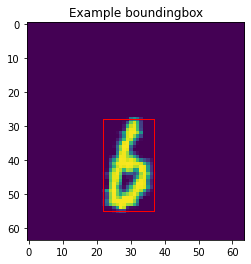

In [169]:
windowsize = 28
preprocessor = transforms.Compose([
                    transforms.RandomRotation((-180,180)),
                    transforms.Resize(int(windowsize * np.random.uniform(low=0.75, high=1.25))),
                    transforms.ToTensor(),
                    RandomPadder(64),
                    EncodingProcedure(4, windowsize, (6, 10, 10))
                ])

num_workers = 0
MNIST_datasets, MNIST_generators = load_MNIST(MNIST_path, preprocessor, num_workers)


a = iter(MNIST_generators['train'])
b = a.next()
image = b[0][0][2]

max_x, min_x, max_y, min_y = BoundingBoxExtraction(image)
plt.plot([max_x, min_x], [min_y, min_y], color="red", linewidth=1)
plt.plot([max_x, min_x], [max_y, max_y], color="red", linewidth=1)
plt.plot([max_x, max_x], [max_y, min_y], color="red", linewidth=1)
plt.plot([min_x, min_x], [max_y, min_y], color="red", linewidth=1)
plt.title("Example boundingbox")
plt.imshow(image.permute(1,2,0))

#compareSlidingAndConvolutional(test_batch[0], cnn, windowsize = 30, stride = 4)
#print("As discovered in the introductory questions: 2 maxpools -> stride = 4")

## 4 Training loop

We are now ready to train our model. The only remaining question is the loss. We want a loss of the form $\sum_{n < N} \sum_{h < H\_out} \sum_{w < W\_out} L(Y\_true[n,:,h,w], Y\_out[n,:,h,w])$,
where 

$L(Y\_true[n,:,h,w], Y\_out[n,:,h,w]) = L\_detection + L\_classification + L\_regression$ such that

- $L\_detection = binary\_cross\_entropy(sigmoid(Y\_out[n,0,h,w]), Y\_true[n,0,h,w])$

If $sigmoid(Y\_out[n,0,h,w]) > 0.5$ and $Y\_true[n,0,h,w] == 1$ ("true positive detection of digit in window $(h,w)$"):
- $L\_classification = negative\_log\_likelihood\_loss(log\_softmax(Y\_out[n,1\!:\!11,h,w]), Y\_true[n,1,h,w])$ 
- $L\_regression = mse(Y\_out[n,-4\!:,h,w], Y\_true[n,-4\!:,h,w])$

Else:
- $L\_classification=0.0$
- $L\_regression=0.0$

Essentially, this loss indicates that we break down the whole task into three subproblems:

a) Is there a digit in the current window ?

If so,

b) What is the digit in the window ?

c) Where is the digit in the window ?

The two last questions only make sense assuming the first question was positively answered, hence the use of a conditional loss. Notice also that we sum the loss not only over samples in a batch, but also over windows. Essentially, the set of windows forming the sliding window procedure can be seen itself as a minibatch of samples. 

**4) Implement the training loop, then train your model for a few epochs.**

In [170]:
device = torch.device('cuda')
print(f"Device {device}.")

model = NewCNN().to(device)
learning_rate = 0.01
momentum = 0.5
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

BCE = nn.BCELoss()
sigmoid = nn.Sigmoid()
NLL = nn.NLLLoss()
MSE = nn.MSELoss()
logSoftmax = nn.LogSoftmax(dim = 1)


def my_loss(Y_out, Y_true):
    
    L_detection = BCE(sigmoid(Y_out[:,0,:,:]), Y_true[:,0,:,:])
    
    TP_mask = (sigmoid(Y_out[:,0,:,:])>0.5) * (Y_true[:,0,:,:]==1)
    TP = torch.where(TP_mask)
    
    L_classification = 0.0
    L_regression = 0.0
    
    if len(TP[0]) > 0:
        L_classification = NLL(logSoftmax(Y_out[TP[0], 1:11, TP[1], TP[2]]), Y_true[TP[0], 1, TP[1], TP[2]].type(torch.long))
        L_regression = MSE(Y_out[TP[0], -4:, TP[1], TP[2]], Y_true[TP[0], -4:, TP[1], TP[2]])
    
    return L_detection + L_classification + L_regression


def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    

    model.train()
    for epoch in range(1, n_epochs + 1):
        batch_loss = 0.0
        c = 0
        cc = 0
        
        print(f"Epoch: {epoch}, begins!")

        
        for samples, labels in train_loader:
            

            images = samples[0].to(device)
            Y_true = samples[1].to(device)
            
            
            Y_true[0,1,:,:] = torch.zeros((10,10)).fill_(labels[0])
            Y_true[1,1,:,:] = torch.zeros((10,10)).fill_(labels[1])
            Y_true[2,1,:,:] = torch.zeros((10,10)).fill_(labels[2])
            Y_true[3,1,:,:] = torch.zeros((10,10)).fill_(labels[3])
            
            '''
            print(labels[0])
            
            
            print("Yellow")
            print(Y_true[0,0,3,0])
            print(Y_true[0,-4:,3,0])

            #plt.plot([30, 30], [0, 30], color="red", linewidth=1)
            #plt.plot([0, 30], [30, 30], color="red", linewidth=1)
            
            plt.plot([12, 12], [0, 30], color="red", linewidth=1)
            plt.plot([12, 42], [30, 30], color="red", linewidth=1)
            plt.plot([42, 42], [0, 30], color="red", linewidth=1)
            
            
            print("Red")
            print(Y_true[0,0,0,3])
            print(Y_true[0,-4:,0,3])
            
            plt.plot([0,30], [12, 12], color="yellow", linewidth=1)
            plt.plot([30, 30], [12, 42], color="yellow", linewidth=1)
            plt.plot([0, 30], [42, 42], color="yellow", linewidth=1)

            
            plt.imshow(images[0].cpu().permute(1,2,0))
            return
            '''
            Y_out = model(images)
            
            loss = loss_fn(Y_out, Y_true)
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
            
            batch_loss += loss.item()
            
            if c % 150 == 0:
                print("Average for the last 150 batches:", round(batch_loss / 150, 3),"----", round((cc / len(train_loader)*100),2), "% complete" )
                batch_loss = 0.0
                c = 0
            
            c += 1
            cc += 1
        

    print("Training complete...")


training_loop(n_epochs=2, optimizer=optimizer, model = model, loss_fn = my_loss, train_loader = MNIST_generators['train'])


Device cuda.
Epoch: 1, begins!
Average for the last 150 batches: 0.024 ---- 0.0 % complete
Average for the last 150 batches: 2.723 ---- 1.0 % complete
Average for the last 150 batches: 2.55 ---- 2.0 % complete
Average for the last 150 batches: 2.51 ---- 3.0 % complete
Average for the last 150 batches: 2.465 ---- 4.0 % complete
Average for the last 150 batches: 2.447 ---- 5.0 % complete
Average for the last 150 batches: 2.434 ---- 6.0 % complete
Average for the last 150 batches: 2.423 ---- 7.0 % complete
Average for the last 150 batches: 2.395 ---- 8.0 % complete
Average for the last 150 batches: 2.372 ---- 9.0 % complete
Average for the last 150 batches: 2.35 ---- 10.0 % complete
Average for the last 150 batches: 2.333 ---- 11.0 % complete
Average for the last 150 batches: 2.318 ---- 12.0 % complete
Average for the last 150 batches: 2.305 ---- 13.0 % complete
Average for the last 150 batches: 2.291 ---- 14.0 % complete
Average for the last 150 batches: 2.259 ---- 15.0 % complete
Averag

Average for the last 150 batches: 1.534 ---- 35.0 % complete
Average for the last 150 batches: 1.568 ---- 36.0 % complete
Average for the last 150 batches: 1.498 ---- 37.0 % complete
Average for the last 150 batches: 1.542 ---- 38.0 % complete
Average for the last 150 batches: 1.553 ---- 39.0 % complete
Average for the last 150 batches: 1.544 ---- 40.0 % complete
Average for the last 150 batches: 1.472 ---- 41.0 % complete
Average for the last 150 batches: 1.518 ---- 42.0 % complete
Average for the last 150 batches: 1.484 ---- 43.0 % complete
Average for the last 150 batches: 1.509 ---- 44.0 % complete
Average for the last 150 batches: 1.543 ---- 45.0 % complete
Average for the last 150 batches: 1.509 ---- 46.0 % complete
Average for the last 150 batches: 1.532 ---- 47.0 % complete
Average for the last 150 batches: 1.485 ---- 48.0 % complete
Average for the last 150 batches: 1.523 ---- 49.0 % complete
Average for the last 150 batches: 1.559 ---- 50.0 % complete
Average for the last 150

## 5 Prediction

Your model should now be trained, great ! But now you may wonder: "How do I predict ?". And indeed it is not so obvious. In our implementation, our model should output a tensor $Y\_out$ with dimensions $(N,15,H\_out,W\_out)$, that is we have one prediction vector per window in the sliding window procedure. We propose the following strategy: among all the predicted vectors, keep the one associated to the window with the highest label classification score. In other word, $\forall n<N$:

a) Compute the max classification scores: $max\_classification\_scores = max_{i=1:11} \{log\_softmax(Y\_out[n,i,:,:])\}$.

b) Extract the indices of the best window: $h\_best,w\_best = argmax_{h<H\_out,w<W\_out} \{max\_classification\_scores[h,w]\}$.

c) Save the prediction associated to the best window. **You will have to convert the predicted bounding box back to the referential of the input image.** 

**5) Implement the predict function.**

tensor(4)
tensor(1)
tensor(2)
tensor([ 0.4215,  1.2630, -0.0808,  0.7957], grad_fn=<SelectBackward>)
tensor(20.6439) tensor(45.8906) tensor(1.5771) tensor(27.8717)


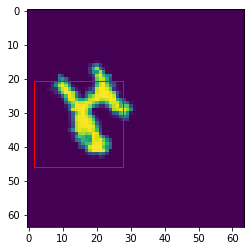

In [234]:
a = iter(MNIST_generators['test'])
b = a.next()
image = b[0][0]
model.to('cpu')


def predict(model, images, windowsize = 28):
    Y_out = model(images)
    Y_shape = Y_out.shape
    softmax = nn.LogSoftmax(dim = 1)
    
    # Check if detections is "worthwhile"
    mask = (Y_out[:,0,:,:] > 0.5)
    indices = torch.where(mask)
    
    Y_above_threshold = torch.zeros(Y_shape)
    Y_above_threshold[indices[0], :, indices[1], indices[2]] = Y_out[indices[0], :, indices[1], indices[2]]
    
    # Find maximum values and corresponding indices (height and width)
    Y_max = torch.max(Y_above_threshold[:,1:11, :,:], dim = 1)
    
    Y_max_values = Y_max[0].view(Y_shape[0], 10*10)
    Y_max_indices = torch.max(Y_max_values, dim=1)[1]
    
    Ws, Hs = Y_max_indices % 10, Y_max_indices // 10
    
    # Get predictions
    predictions = Y_max[1][torch.arange(0,30), Ws, Hs]
    
    return (predictions, Ws, Hs, Y_out)
        
pred = predict(model, image)
stride = 4


print(pred[0][12])

w = pred[1][12]
print(pred[1][12])

h = pred[2][12]
print(pred[2][12])

boundry = pred[3][12,-4:,pred[1][12], pred[2][12]]
print(pred[3][12,-4:,pred[1][12], pred[2][12]])

new_h = h * stride
new_w = w * stride

start_h = new_h + 30 * boundry[0].item()
end_h = new_h + 30 * boundry[1].item()

start_w = new_w + 30 * boundry[2].item()
end_w = new_w + 30 * boundry[3].item()

print(start_h, end_h, start_w, end_w)
max_y, min_y, min_x, max_x = start_h.item(), end_h.item(), start_w.item(), end_w.item()


plt.plot([max_x, min_x], [min_y, min_y], color="red", linewidth=1)
plt.plot([max_x, min_x], [max_y, max_y], color="red", linewidth=1)
plt.plot([max_x, max_x], [max_y, min_y], color="red", linewidth=1)
plt.plot([min_x, min_x], [max_y, min_y], color="red", linewidth=1)
plt.imshow(image[12].permute(1,2,0))
    


## 6 Visualization

Time to test your hard work by visualizing your predictions ! 

**6) Implement a function that will display the 30 images contained in the test set, with the true bounding boxes in green and the predicted bounding boxes in red overlayed over images. Each image will be titled with its groundtruth and predicted labels. You can use fig, axes = plt.subplots(6, 5, figsize=(20, 16)) in order to place the images conveniently.**

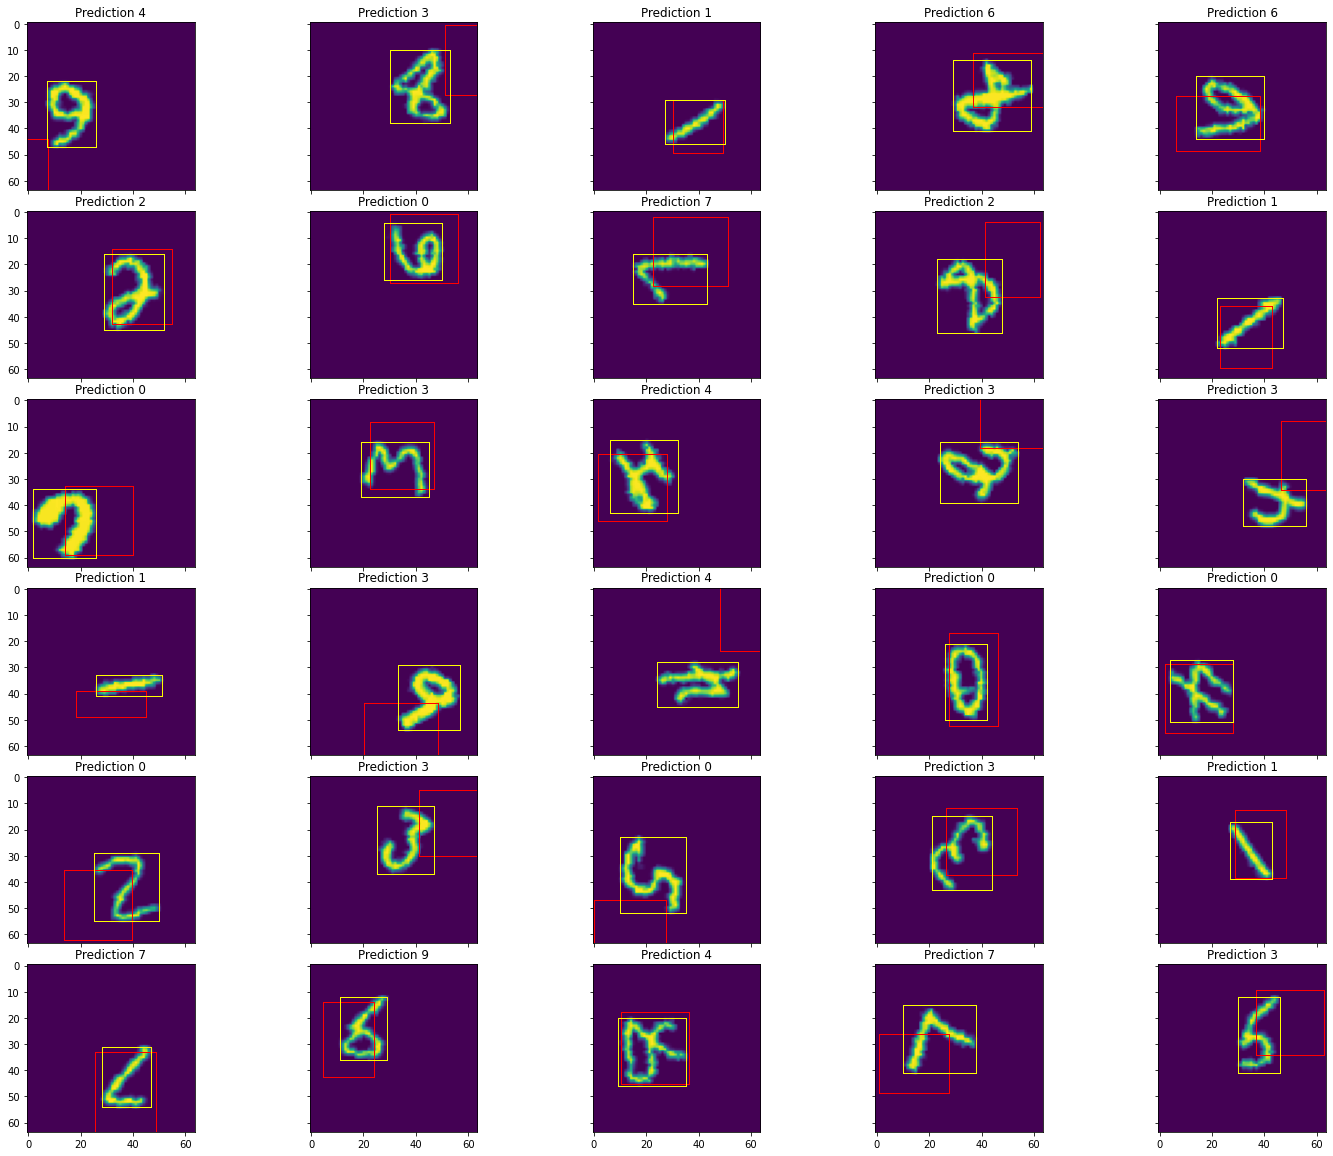

In [236]:
# My model clearly isnt perfect. Since the deadline was extended i tried to fix some of the faults in the original
# submission. Doing this made my model a lot better, but my code is more spaghetti than ever :')

# It's cool regardless to see that in most cases it's on the track of something! 

# A deeper network would probably help alot! I was a bit scared to try as i would have to introduce padding to get it deep
# and i can only imagine that that would screw with the final output

# In my original submission i used the network "MyCNN", mostly because i was curious to see if such a simple network
# would work. It seems the "new" network is a lot better. It's also only trained for two epochs, i would imagine more 
# training would help a bunch.


pred = predict(model, image)
stride = 4
windowsize = 28

fig, axes = plt.subplots(6,5, figsize=(20,16), sharex=True, sharey=True)
fig.tight_layout()

for i in range(5):
    for j in range(6):
        
        w = pred[1][i*6 + j]
        h = pred[2][i*6 + j]

        boundry = pred[3][i*6 + j,-4:,pred[1][i*6 + j], pred[2][i*6 + j]]

        new_h = h * stride
        new_w = w * stride

        start_h = new_h + 30 * boundry[0].item()
        end_h = new_h + 30 * boundry[1].item()

        start_w = new_w + 30 * boundry[2].item()
        end_w = new_w + 30 * boundry[3].item()

        max_y, min_y, min_x, max_x = start_h.item(), end_h.item(), start_w.item(), end_w.item()
        
        axes.flat[i*6 + j].axes.set_title(f"Prediction {pred[0][i*6 + j].item()}")  
        axes.flat[i*6 + j].plot([max_x, min_x], [min_y, min_y], color="red", linewidth=1)
        axes.flat[i*6 + j].plot([max_x, min_x], [max_y, max_y], color="red", linewidth=1)
        axes.flat[i*6 + j].plot([max_x, max_x], [max_y, min_y], color="red", linewidth=1)
        axes.flat[i*6 + j].plot([min_x, min_x], [max_y, min_y], color="red", linewidth=1)
        
        max_x, min_x, max_y, min_y = BoundingBoxExtraction(image[i*6 + j])
        axes.flat[i*6 + j].plot([max_x, min_x], [min_y, min_y], color="yellow", linewidth=1)
        axes.flat[i*6 + j].plot([max_x, min_x], [max_y, max_y], color="yellow", linewidth=1)
        axes.flat[i*6 + j].plot([max_x, max_x], [max_y, min_y], color="yellow", linewidth=1)
        axes.flat[i*6 + j].plot([min_x, min_x], [max_y, min_y], color="yellow", linewidth=1)
        
        axes.flat[i*6 + j].imshow(image[i*6 + j].permute(1,2,0)) 
        
        

In [12]:


# This cell contains a bunch of junk i wasnt sure if i was going to need. Please ignore :))









def encodeBatch(model, batch, stride, window_size):
    N, _, H_out, W_out = model(batch[0]).shape
    bounding_boxes = torch.zeros(size=(N, 4))
    Y_true = torch.zeros(size=(N, 6, H_out, W_out))
    
    for n in range(N):
        max_x, min_x, max_y, min_y = BoundingBoxExtraction(batch[0][n])
        box = torch.tensor([min_y, max_y, min_x, max_x])
        bounding_boxes[n,:] = box

        top = bounding_boxes[n,0]
        bottom = bounding_boxes[n,1]
        left = bounding_boxes[n,2]
        right = bounding_boxes[n,3]
        
        for h in range(H_out):
            for w in range(W_out):
                
                h_start = h * stride
                w_start = w * stride
                h_end = h * stride + window_size
                w_end = w * stride + window_size
                                
                
                
                if not(top > h_end or bottom < h_start or right < w_start or left > w_end):
                    y2 = 0 if top <= h_start else (1 - (window_size - (top - h_start)) / window_size).item()
                    y3 = 1 if bottom >= h_end else ((window_size - (h_end - bottom)) / window_size).item()
                    y4 = 0 if left <= w_start else (1 - (window_size - (left - w_start)) / window_size).item()
                    y5 = 1 if right >= w_end else ((window_size - (w_end - right)) / window_size).item()
                    y2, y3, y4, y5 = [ round(elem, 2) for elem in [y2,y3,y4,y5] ]
                    
                    Y_true[n,:,h,w] = torch.tensor((1, batch[1][n], y2,y3,y4,y5))
    return Y_true
    



# for-loop vectorization
n = 1
y = 6
h = 7
w = 7


vec_test = torch.rand((n, y, h, w))
vec_test_res = torch.rand((n,y,h,w))

def test_loop(tensor = vec_test, result = vec_test_res):
    N_in, Y_in, H_in, W_in = vec_test.shape
    example_out = torch.zeros((N_in, 1, H_in, W_in))

    for n in range(N_in):
        
        
        
        for h in range(H_in):
            for w in range(W_in):
                #if vec_test[n,0,h,w] > 0.5:
                example_out[n,:,h,w] = binary_cross_entropy(sigmoid(vec_test[n,:,h,w]), vec_test_res[n,:,h,w])
                    
                    
    return example_out

def test_vectorized(t = vec_test, r = vec_test_res):
    N_in, Y_in, H_in, W_in = vec_test.shape
    out = torch.zeros((N_in, 1, H_in, W_in))
    for n in range(N_in):
        print(sigmoid(vec_test).shape)
        print(binary_cross_entropy(sigmoid(vec_test @ vec_test_res))
        print(binary_cross_entropy(sigmoid(vec_test), vec_test_res))
        #out = binary_cross_entropy(sigmoid(vec_test), vec_test_res)
    
    return out
    
    

print(test_loop())
print(test_vectorized())
              
              
# loss function
def my_loss(output, target, BCE = BCE, sigmoid = sigmoid, NLL = NLL, mse = MSE, logSoftmax = logSoftmax):
    N_in, Y_in, H_in, W_in = output.shape
    out = torch.zeros((N_in, 1, H_in, W_in))

    for n in range(N_in):
        for h in range(H_in):
            for w in range(W_in):
                sig = sigmoid(output[n,0,h,w])
                L_detection = BCE(sig, target[n,0,h,w])
                L_classification = 0.0
                L_regression = 0.0

                if sig > 0.5 and target[n,0,h,w] == 1:
                    L_classification = NLL(logSoftmax(output[n, 1:11, h, w]), target[n,1,h,w])
                    L_regression = mse(output[n,-4:, h, w], target[n, -4:, h, w])
                    
                loss = L_detection + L_classification + L_regression
                out[n, :, h, w] = loss

    return out
    
def multidim_intersect(arr1, arr2):
    arr1_view = arr1.view([('',arr1.dtype)]*arr1.shape[1])
    arr2_view = arr2.view([('',arr2.dtype)]*arr2.shape[1])
    intersected = np.intersect1d(arr1_view, arr2_view)
    return intersected.view(arr1.dtype).reshape(-1, arr1.shape[1])


def loss_fn2(Y_out, Y_true):
    
    sigmoidal_values = sigmoid(Y_out)
    L_detection = BCE(sigmoidal_values[:,0,:,:], Y_true[:,0,:,:])
    
    sigmoidal_gt = torch.where(sigmoidal_values[:,0,:,:] > 0.5, 1, 0)
    positive_detection = torch.where(Y_true[:,0,:,:] == 1, 1, 0)
    
    sigmoidal_indices = torch.nonzero(sigmoidal_gt).numpy()
    positive_indices = torch.nonzero(positive_detection).numpy()
    
    i = torch.from_numpy(multidim_intersect(sigmoidal_indices, positive_indices))
    
    log_sm = logSoftmax(Y_out[i[:,0], 1:11, i[:,1], i[:,2]])
    L_classification = NLL(log_sm, Y_true[i[:,0], 1, i[:,1], i[:,2]].type(torch.long))
    L_regression = MSE(Y_out[i[:,0], -4:, i[:,1], i[:,2]], Y_true[i[:,0], -4:, i[:,1], i[:,2]])
    
    return L_detection + L_classification + L_regression

    
    #print(Y_true[i[:,0], :, i[:,1], i[:,2]][:,0])

    #print(i[:10])
    #print(i[:10][:,2])
    
    #print(sigmoidal_values[i[:10][:,0], :, i[:10][:,1], i[:10][:,2]][:,0])

    #indices.unsqueeze_(dim=1)
    #indices.view(30,9,9)
    #print(i.shape)
    
    
    # Overlap
    
    #print("sigmoidal")
    #print(sigmoidal_gt.shape)
    #print(sigmoidal_indices.shape)
    
    #print("positive")
    #print(positive_detection.shape)
    #print(positive_indices.shape)
    
    #print(sigmoidal_indices[1:10])
    #print(positive_indices[1:10])
    
    
    #print(np.intersect1d(sigmoidal_indices.numpy(), positive_indices.numpy()))
    
    #print(torch.eq(sigmoidal_indices[1:10], positive_indices[1:10]))
    
    #indices = torch.nonzero(torch.eq(sigmoidal_gt, positive_detection))
    #t = tuple(torch.nonzero(sigmoidal_gt))
    
    
    
    
   # print(torch.nonzero(sigmoidal_gt)[1])
   # print(sigmoidal_values[tuple(torch.nonzero(sigmoidal_gt)[1])])
   # print(sigmoidal_values[0,:,0,1]) 
    
    # Må nok gjøre noe slikt. Indexsene blir feil om ikke (Kan kanskje transpose?)
    
    
    #print(torch.nonzero(comparison))
    #print(sigmoidal_gt[torch.nonzero(sigmoidal_gt)])
    #print(sigmoidal_gt)



'''

batch = test_batch
stride = 4
window_size = 30
N = len(batch[0])
H_out = 9
W_out = 9
bounding_boxes = torch.zeros(size=(N, 4))       # For each image there is a single boundingbox (Four lines, hence 4)
Y_true = torch.zeros(size=(N, 6, H_out, W_out)) # N = batchsize, 6 = y_size, H_out and W_out correspond to "windows" count
for n in range(N):
    # Bounding box extraction:
    max_x, min_x, max_y, min_y = BoundingBoxExtraction(batch[0][n])
    #box = torch.tensor([[max_y],[min_y],[min_x],[max_y]])
    box = torch.tensor([min_y, max_y, min_x, max_x])
    bounding_boxes[n,:] = box
    
    # Bounding box coordinates:
    top = bounding_boxes[n,0].int()
    bottom = bounding_boxes[n,1].int()
    left = bounding_boxes[n,2].int()
    right = bounding_boxes[n,3].int()
    for h in range(H_out):
        for w in range(W_out):
            # Coordinates of the window (h,w):
            h_start = h * stride
            w_start = w * stride
            h_end = h * stride + window_size
            w_end = w * stride + window_size
            
            #print(h_start, h_end, w_start, w_end)
            # If a digit is visible in the window (h,w) <==>
            # rectangles (top, bottom, left, right) and (h_start, h_end, w_start, w_end) intersect:

            # Separating axis theorem
            #not(bottom > h_end or top < h_start or left > w_end or right < w_start)
            if not(bottom > h_end or top < h_start or left > w_end or right < w_start):
                
                Y_true[n,:,h,w] = torch.tensor((1,batch[1][n], top, bottom, left, right)) 
'''
print()

              
                  #print("  X:", Y_max_indices % 9, "Y:",Y_max_indices // 9)
    #print("  X:", Y_max_indices[1] % 9, "Y:",Y_max_indices[1] // 9)
    
    #print(Y_max[0].shape)
    #print(Y_max[0][5])
    #print(Y_max[1][5])
    
    #plt.imshow(images[5].permute(1,2,0))
    
    
    
    
    #for n in range(Y_shape[0]):
    
    #    max_classification_score = torch.zeros(11)
    #    for i in range(1,12):
    #        m = torch.max(softmax(Y_above_threshold[n, i, :, :]))
    #        max_classification_score[i-1] = m
    #        
    #        x = torch.argmax(Y_above_threshold[n, i, :, :], 1)
    #        print(m, m.indices, x)
            
                        
        
    #    print(max_classification_score)
    #    print(torch.argmax(max_classification_score))

SyntaxError: invalid syntax (<ipython-input-12-ce4049ad368a>, line 81)

In [ ]:
m = nn.LogSoftmax(dim=0)
input = torch.randn(2, 3)
output = m(input)
print(output)